--------------------------------------------------------------------------------------------------------------------------------------
### TSRoots for Global Optimization of 2D Himmelblau function
--------------------------------------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------------------------------------
 In this notebook, we extend the use of TSRoots for the global optimization of a 2D multimodal functions via Bayesian Optimization (BO). This notebook is intended to give users a starting point for the application of TSRoots to multidimensional settings where TSRoots has been proven to be efficient in comparison to other BO techniques (you can refer to our published journals [here](https://openreview.net/forum?id=IpRLTVblaV) [1,2]).

----------------------------------------------------------------------------------------------------------------------------------------------

Import necessary libraries and components, and plotting utilities.

In [1]:
# Import TSRoots from tsroots package
from tsroots.optim import TSRoots
from tsroots.utils import *
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output

# Add inline plotting
%matplotlib inline

Using device: cuda


----------------------------------------------------------------------------------------------------------------------------------------
#### Define Himmelblau's Function
----------------------------------------------------------------------------------------------------------------------------------------
 Himmelblau's function is a multi-modal function (i.e, with multiple global optimum points). The function is defined by:
 $$f(x,y) = (x^2 + y -11)^2 + (x + y^2 - 7)^2$$ In particular, it has four identical local minima (Wikipedia):
 - $f(3.0, 2.0) = 0.0$,
  - $f(-2.805118, 3.131312) = 0.0$,
  - $f(-3.779310, -3.283186) = 0.0$,
  - $f(3.584428, -1.848126) = 0.0$.

In [2]:
# Define the Himmelblau's function to take in an n x d matrix
def himmelblau(X):
    x = X[:, 0]
    y = X[:, 1]
    return (x**2 + y - 11)**2 + (x + y**2 - 7)**2

The visualization is shown below:

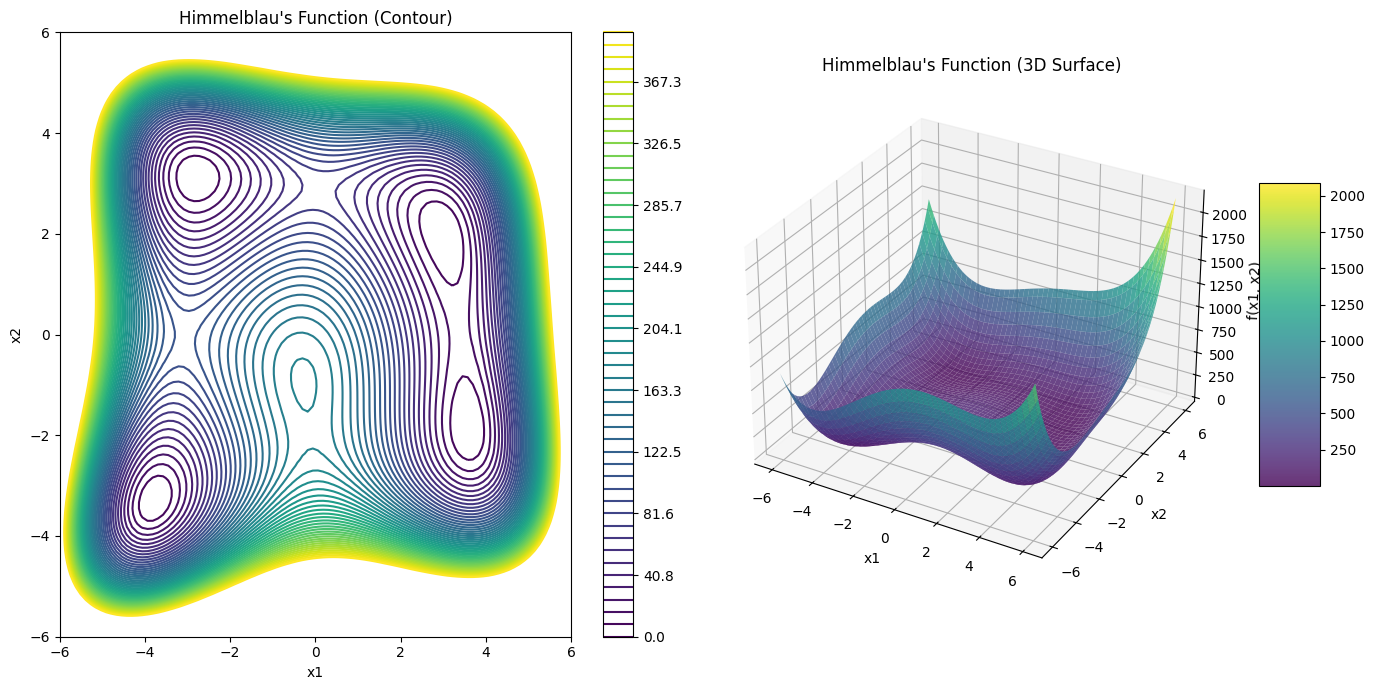

In [3]:
# Generate grid of data points
grid_vals = np.linspace(-6, 6, 100)
X1, X2 = np.meshgrid(grid_vals, grid_vals)
X = np.column_stack([X1.ravel(), X2.ravel()])
Z = himmelblau(X).reshape(X1.shape)

# compute output mean and std for normalization in BO loop.
mean_Y_true = np.mean(Z)
std_Y_true = np.std(Z)

# Create the figure
fig = plt.figure(figsize=(14, 7))

# 2D Contour Plot
ax1 = fig.add_subplot(1, 2, 1)
contour_levels = np.linspace(Z.min(), 400, 50)
contour = ax1.contour(X1, X2, Z, levels=contour_levels, cmap='viridis')
ax1.set_title("Himmelblau's Function (Contour)")
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
fig.colorbar(contour, ax=ax1)

# 3D Surface Plot
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
surf = ax2.plot_surface(X1, X2, Z, cmap='viridis', edgecolor='none', alpha=0.8)
fig.colorbar(surf, ax=ax2, shrink=0.5, aspect=5)
ax2.set_title("Himmelblau's Function (3D Surface)")
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_zlabel('f(x1, x2)')

plt.tight_layout()
plt.show()

--------------------------------------------------------------------------------------------------------------------------------------------
#### Set Up Bayesian Optimization Parameters
--------------------------------------------------------------------------------------------------------------------------------------------

In [4]:
lbX = np.array([-6, -6])
ubX = np.array([6, 6])
no_sample = 10
D = 2
Seed = 22
noise_level = 1e-3

--------------------------------------------------------------------------------------------------------------------------------------------
#### Generate Initial Data
--------------------------------------------------------------------------------------------------------------------------------------------
Generate initial random samples and compute their function values.

In [5]:
# Generate initial data
X_r, X_s = generate_Xdata(no_sample, D, Seed, lbX, ubX)
Y_r, Y_s = generate_Ydata(himmelblau, X_r)

Y_r, _ = generate_Ydata(himmelblau, X_r)
# Add noise to output value
Y_r = Y_r + np.random.normal(0, noise_level)
# z-score normalization of output values
Y_s = (((Y_r - mean_Y_true) / std_Y_true)).flatten()

--------------------------------------------------------------------------------------------------------------------------------------------
#### Initialize the TSRoots Class
--------------------------------------------------------------------------------------------------------------------------------------------
Initialize `TSRoots` with the initial samples and set bounds for Bayesian Optimization.

In [6]:
lbS = -np.ones(D)
ubS = np.ones(D)
TSRoots_BO = TSRoots(X_s, Y_s.flatten(), lbS, ubS, noise_level=noise_level)

--------------------------------------------------------------------------------------------------------------------------------------------
####  Run the Bayesian Optimization Loop
--------------------------------------------------------------------------------------------------------------------------------------------
Set up the optimization loop, running for a defined number of iterations. Each iteration uses TS-roots for new sample points and updates the best-found solution.

# We enumerate all possible combinations...


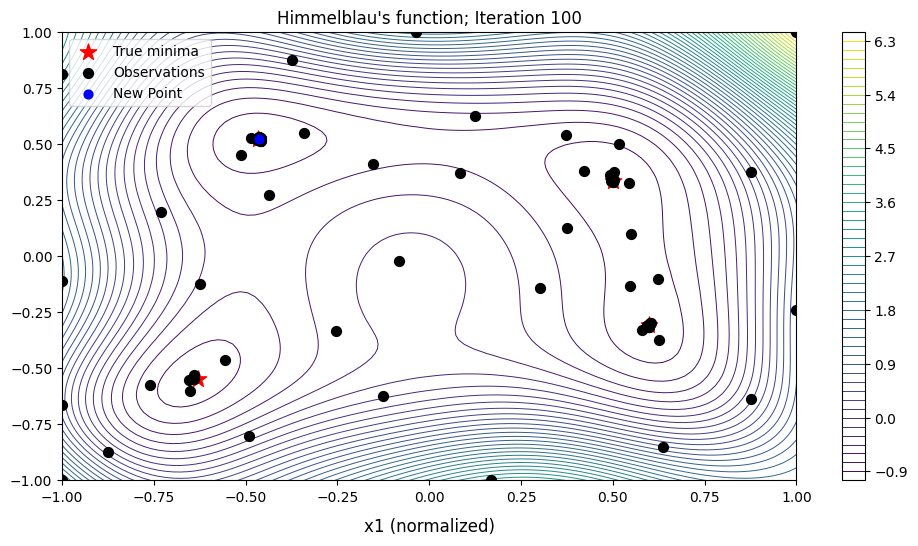

# BO iter = 100; y_best = 0.0011269717639558465...


In [7]:
start = time.time()
k = 100  # Number of iterations
bo_iterMax = 200


plt.ion()  # Turn on interactive mode
for i in range(k):
    # Clear the output to display updated plot dynamically
    clear_output(wait=True)
    plt.figure(figsize=(10, 6))

    # Update TSRoots object and get new points
    TSRoots_BO = TSRoots(X_s, Y_s.flatten(), lbS, ubS, noise_level=noise_level, learning_rate=0.05)
    X_s_new, Y_s_new, _ = TSRoots_BO.xnew_TSroots(plot=True)
    X_r_new = unscale_Xn(X_s_new.reshape(-1, D), lbX, ubX)
    Y_r_new, _ = generate_Ydata(himmelblau, X_r_new)

    # Update datasets with new samples
    X_r = np.append(X_r, X_r_new).reshape(-1, D)
    Y_r = np.append(Y_r, Y_r_new)

    # Normalize updated data
    X_s = np.append(X_s, X_s_new).reshape(-1, D)
    #Y_s = scale_Y(Y_r)
    Y_s = ((Y_r - mean_Y_true) / std_Y_true)

    # Extract the best solution found so far
    X_r_best, Y_r_best = TSRoots.extract_min(X_r, Y_r)

    # Optionally, add legend and show the plot
    plt.legend(loc='upper left')

    # Add title in latex format
    plt.title(f"Himmelblau's function; Iteration {i+1}")

    plt.show()

    # Report the best-found solution at each iteration
    if i < bo_iterMax:
        print(f"# BO iter = {i + 1}; y_best = {Y_r_best}...")
    else:
        print(f"# BO iter = {i + 1}; y_best = {Y_r_best}##.")

    plt.pause(0.5)  # Adjust for dynamic display


#### <span style="color:red">References</span>
[1] Adebiyi, Taiwo, Bach Do, and Ruda Zhang. Gaussian Process Thompson Sampling via Rootfinding. In _NeurIPS 2024 Workshop on Bayesian Decision-Making and Uncertainty_, 2024.

[2] Adebiyi, Taiwo, Bach Do, and Ruda Zhang. Optimizing Posterior Samples for Bayesian Optimization via Rootfinding. In _Proceedings of the Thirteenth International Conference on Learning Representations_, 2025.